## Predicting T cell Epitopes in cockroach antigens

Bla g allergens are major targets of IgE responses associated with cockroach allergies. Epitopes in cockroach antigens have been studied by the group of Alessandro Sette.
This examples shows how we can use epitopepredict to compare their experimental results to the predictions. Twenty-five distinct Bla g regions are recognized by T cell responses from allergic individuals Ag

This workflow computes sequence regions with high bovine T cell epitope potential from selected antigens. This is done by finding promiscuous binders (present in multiple alleles) using NetMHCIIpan class II binding prediction methods. Cutoffs are allele-specific. NetMHCIIpan (Nielsen et al., 2008) is an artificial neural network algorithm trained on binding data for multiple MHC-II alleles. MHC-II alleles used are 

### References

* C. Oseroff et al., “Analysis of T Cell Responses to the Major Allergens from German Cockroach: Epitope Specificity and Relationship to IgE Production,” J. Immunol., vol. 189, no. 2, pp. 679–688, 2012. http://www.jimmunol.org/content/189/2/679
*  Oseroff C., J. Sidney, et al., "Molecular determinants of T cell epitope recognition to the common Timothy grass allergen." J. Immunol. 2010. http://www.jimmunol.org/content/185/2/943

In [1]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
import epitopepredict as ep
from epitopepredict import base, sequtils, plotting, peptutils, analysis
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt
import seaborn as sns

##  Alleles
Each peptide was predicted for the capacity to bind to a panel of 20 HLA class II alleles (DPA1*0103/DPB1*0201, DPA1*0201/DPB1*0101, DPA1*0201/DPB1*0501, DPA1*0301/DPB1*0402, DQA1*0101/DQB1*0501, DQA1*0301/DQB1*0302, DQA1*0401/DQB1*0402, DQA1*0501/DQB1*0301, DRB1*0101, DRB1*0301, DRB1*0401, DRB1*0405, DRB1*0701, DRB1*0802, DRB1*1101, DRB1*1302, DRB1*1501, DRB3*0101, DRB4*0101, DRB5*0101) using the consensus prediction described by Wang et al. (35). Peptides with predicted binding scores in the top 20% for a given allele were considered potential binders, and the number of HLA molecules each peptide was predicted to bind was enumerated. All peptides predicted to bind seven or more HLA molecules were selected for synthesis and further study.

In [2]:
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')
my_alleles = ['HLA-DPA10103-DPB10201', 'HLA-DPA10201-DPB10101', 'HLA-DPA10201-DPB10501', 'HLA-DPA10301-DPB10402', 
            'HLA-DQA0101-DQB10501', 'HLA-DQA10301-DQB10302','HLA-DQA10401-DQB10402', 'HLA-DQA10501-DQB10301', 
            'HLA-DRB1*0101', 'HLA-DRB1*0301', 'HLA-DRB1*0401', 'HLA-DRB1*0405', 'HLA-DRB1*0701', 'HLA-DRB1*0802', 'HLA-DRB1*1101', 
            'HLA-DRB1*1302','HLA-DRB1*1501', 'HLA-DRB3*0101', 'HLA-DRB4*0101', 'HLA-DRB5*0101']
for i in my_alleles:
    print(i)
prots = ep.fasta_to_dataframe('cockroach_allergens.fa')
prots

HLA-DPA10103-DPB10201
HLA-DPA10201-DPB10101
HLA-DPA10201-DPB10501
HLA-DPA10301-DPB10402
HLA-DQA0101-DQB10501
HLA-DQA10301-DQB10302
HLA-DQA10401-DQB10402
HLA-DQA10501-DQB10301
HLA-DRB1*0101
HLA-DRB1*0301
HLA-DRB1*0401
HLA-DRB1*0405
HLA-DRB1*0701
HLA-DRB1*0802
HLA-DRB1*1101
HLA-DRB1*1302
HLA-DRB1*1501
HLA-DRB3*0101
HLA-DRB4*0101
HLA-DRB5*0101


,locus_tag,translation,description,type
0,Bla-g-1,NAIEFLNNIHDLLGIPHIPVTARKHHRRGVGITGLIDDIIAILPVD...,Bla-g-1,CDS
1,Bla-g-2,MIGLKLVTVLFAVATITHAAELQRVPLYKLVHVFINTQYAGITKIG...,Bla-g-2,CDS
2,Bla-g-4,AVLALCATDTLANEDCFRHESLVPNLDYERFRGSWIIAAGTSEALT...,Bla-g-4,CDS
3,Bla-g-5,MAPSYKLTYCPVKALGEPIRFLLSYGEKDFEDYRFQEGDWPNLKPS...,Bla-g-5,CDS
4,Bla-g-6.0101,MDELPPEQIQLLKKAFDAFDREKKGCISTEMVGTILEMLGHRLDDD...,Bla-g-6.0101,CDS
5,Bla-g-6.0201,MDEIPAEQVVLLKKAFDAFDREKKGCISTEMVGTILEMLGTRLDQD...,Bla-g-6.0201,CDS
6,Bla-g-6.0301,MADEQLQLPPEQISVLRKAFDAFDREKSGSISTNMVEEILRLMGQP...,Bla-g-6.0301,CDS
7,Bla-g-7,MDAIKKKMQAMKLEKDNAMDRALLCEQQARDANIRAEKAEEEARSL...,Bla-g-7,CDS


In [ ]:
reload(base)
P = base.get_predictor('netmhciipan')
#na = P.get_alleles()
b = P.predict_sequences(prots, alleles=my_alleles, cpus=8)#, show_cmd=True)
b.head()

## The promiscuity versus ranking approach

There are two broadly different approaches to computational selection of potentially dominant epitopes. The promiscuity method finds high scoring binders above the percentile (allele-specific) cutoff in greater than n alleles. The ranked approach calculates the median rank over all alleles and sorts the binders in ascending order. One may then take the top percentage of these binders as suited. We use the former method here as it lends itself better to the detection of clusters of binders.  Though they do give similar results as shown in the venn diagram.

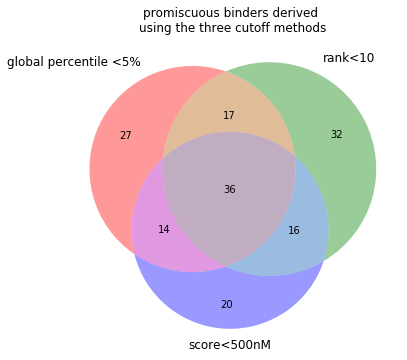

In [23]:
rb = P.ranked_binders(cutoff=20)
rb = P.promiscuous_binders(n=3, cutoff_method='rank', cutoff=10)
pb = P.promiscuous_binders(n=3, cutoff=.95)
pb2 = P.promiscuous_binders(n=3, cutoff_method='score', cutoff=500)
fig,ax=plt.subplots(1,1,figsize=(6,6))
ep.utilities.venndiagram([pb.peptide, rb.peptide, pb2.peptide],
                      ['global percentile <5%','rank<10', 'score<500nM'],ax=ax)
txt=ax.set_title('promiscuous binders derived \nusing the three cutoff methods')
plt.savefig('promisc_comparison.png',dpi=150)

## Compute clusters of promiscuous binders

Here we have detected clusters of MHC II binders. These clusters vary in length and for peptides synthesis we must create a list of 20-mers covering shorter sequences or splitting longer sequences into 2. For the 20mers hydrophobicity and net charge are calculated.

In [7]:
pb=P.promiscuous_binders(n=3)#, cutoff_method='score', cutoff=500)
#print (pb[:20])
reload(analysis)
cl = analysis.find_clusters(pb, min_binders=2)
final = analysis.create_nmers(cl, prots, length=20, margin=2, key='20mer')
final

       name  start  end  binders  length locus_tag  \
5   Bla-g-1    313  342        7      29   Bla-g-1   
15  Bla-g-5    148  168        7      20   Bla-g-5   
12  Bla-g-4    123  142        6      19   Bla-g-4   
6   Bla-g-1    408  432        5      24   Bla-g-1   
8   Bla-g-2      9   42        4      33   Bla-g-2   

                                          translation  
5   NAIEFLNNIHDLLGIPHIPVTARKHHRRGVGITGLIDDIIAILPVD...  
15  MAPSYKLTYCPVKALGEPIRFLLSYGEKDFEDYRFQEGDWPNLKPS...  
12  AVLALCATDTLANEDCFRHESLVPNLDYERFRGSWIIAAGTSEALT...  
6   NAIEFLNNIHDLLGIPHIPVTARKHHRRGVGITGLIDDIIAILPVD...  
8   MIGLKLVTVLFAVATITHAAELQRVPLYKLVHVFINTQYAGITKIG...  


,name,start,end,binders,length,locus_tag,20mer
0,Bla-g-1,1,13,2,12,Bla-g-1,AIEFLNNIHDLLGIPHIPVT
1,Bla-g-1,32,55,4,23,Bla-g-1,NAIEFLNNIHDLLGIPHIPV
2,Bla-g-1,32,55,4,23,Bla-g-1,EFLNNIHDLLGIPHIPVTAR
3,Bla-g-1,103,117,3,14,Bla-g-1,VDHIIELIHQIFNIVRDTRG
4,Bla-g-1,126,147,4,21,Bla-g-1,FLALIPTDQVLAIAADYLAN
5,Bla-g-1,174,191,4,17,Bla-g-1,LPEFKNFLNFLQTNGLNAIE
6,Bla-g-1,313,342,7,29,Bla-g-1,NAIEFLNNIHDLLGIPHIPV
7,Bla-g-1,313,342,7,29,Bla-g-1,HDLLGIPHIPVTARKHHRRG
8,Bla-g-1,408,432,5,24,Bla-g-1,NAIEFLNNIHDLLGIPHIPV
9,Bla-g-1,408,432,5,24,Bla-g-1,FLNNIHDLLGIPHIPVTARK


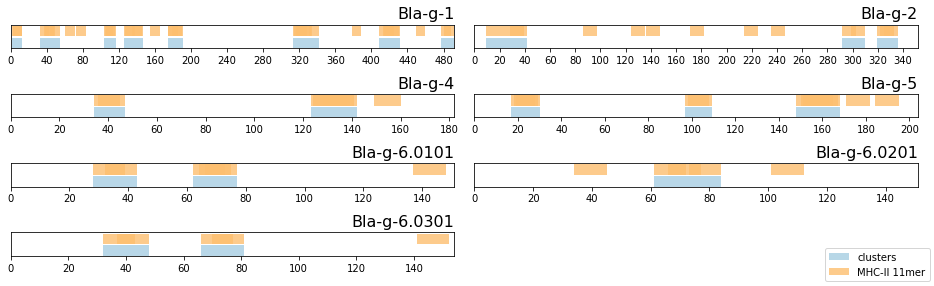

In [8]:
reload(plotting)
bc = ep.get_coords(pb)
r1 = plotting.binders_to_coords(bc)
c = ep.plotting.binders_to_coords(cl)
f = ep.plotting.plot_overview(prots, coords={'clusters':c,'MHC-II 11mer':r1},
                              cols=2, figsize=(13,4))
plt.savefig('cockroach_clusters.png',dpi=150)

In [ ]:
reload(plotting)
#print (P.get_names())
prot='Bla-g-6.0101'
ax = plotting.plot_multiple([P],names=prots.locus_tag,cutoff=.95, cutoff_method='default',n=1, legend=True, figsize=(12,5),regions=cl)
#plt.show()
plt.savefig('cockroach_%s.png' %prot, dpi=150)

In [ ]:
reload(plotting)
from bokeh.io import show, output_notebook
output_notebook()
p = plotting.bokeh_plot_tracks([P],name='Bla-g-5',cutoff=.95,n=2,width=800)
show(p)
p = plotting.bokeh_plot_tracks([P],name='Bla-g-5',cutoff=500,cutoff_method='score',n=2,width=800)
#p= plotting.bokeh_plot_grid(P, name='Bla-g-5', width=800)
show(p)

## Test for effect of cutoffs/method on epitope discovery rate

195 peptides ranking in the top 40% of predicted affinities for 7 or more of 20 HLA class II alleles were selected in Sette study. These were arranged into 13 pools which were were tested with PBMC cultures for production of IL-5 (Th2) and IFN-γ (Th1). 32 unique peptides were identified that elicited a positive response in at least one donor. These were joined into overlapping contiguous epitopes defining 25 distinct antigenic regions 15–20 in length. Their results indicated that a small number of epitopes that elicit the most dominant and prevalent responses encompass a significant fraction of the total response in this population of donors.
Based on previous timothy grass studies, which had shown that predictions of this level of stringency would identify ∼75% of the total response detected with complete sets of overlapping peptides
Here we test the use of 

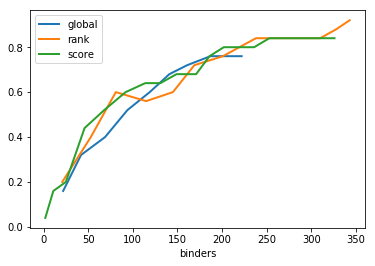

In [28]:
reload(analysis)
resp = pd.read_csv('cockroach_responses.csv')
resp['start'] = resp.pos
resp['end'] = resp.sequence.str.len()+resp.pos
#print (resp)
def overlap(x):
    return x.seq
res=[]
methods = {'rank': range(2,40,3), 'score':range(50,2000,100), 'global':np.arange(.9,.99,.01)}
f,ax=plt.subplots(1,1)
#for n in range(1,10): 
for m in methods:
    rng = methods[m]
    for n in rng:
        pb=P.promiscuous_binders(n=3, cutoff_method=m, cutoff=n)
        #cl = analysis.find_clusters(pb, min_binders=2)
        x = analysis.get_overlaps(resp,pb,how='inside')
        found=x[x.overlap>0]
        res.append((len(pb),len(found)/len(resp),m))
res=pd.DataFrame(res,columns=['binders','positives','method'])

for i,df in res.groupby('method'):
    df.plot(0,1,kind='line',lw=2,ax=ax, label=i)
plt.savefig('promiscuity_tpr.png',dpi=150)
#res

## Using the command line interface

You can re-produce most of this analysis, without using Python, from the command line. The configuration settings are given below. Put this in a file file.conf. You can also place the list of alleles in a text file for convenience. Then run:

`epitopepredict -c file.conf -r`

file.conf:
```
[base]
cpus = 4
cutoff = .95
cutoff_method = default
fasta_header_sep =  
genome_analysis = no
mhc2_alleles = mhc2alleles.txt
mhc2_length = 11
n = 3
names = 
overwrite = yes
path = results_cockroach
predictors = netmhciipan
sequence_file = cockroach_allergens.fa
verbose = yes
```

mhc2alleles.txt:
```
HLA-DPA10103-DPB10201
HLA-DPA10201-DPB10101
HLA-DPA10201-DPB10501
HLA-DPA10301-DPB10402
HLA-DQA0101-DQB10501
HLA-DQA10301-DQB10302
HLA-DQA10401-DQB10402
HLA-DQA10501-DQB10301
HLA-DRB1*0101
HLA-DRB1*0301
HLA-DRB1*0401
HLA-DRB1*0405
HLA-DRB1*0701
HLA-DRB1*0802
HLA-DRB1*1101
HLA-DRB1*1302
HLA-DRB1*1501
HLA-DRB3*0101
HLA-DRB4*0101
HLA-DRB5*0101


```